# Import libraries

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math  
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential 
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns 
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
import yfinance as yf

print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.9.2
Num GPUs: 1


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Preprocessing

In [ ]:
def load(symbol,start_date,end_date):
  df = yf.download(symbol, start=start_date, end=end_date)
  return df

In [ ]:
def count(start_date,end_date):
  end_date_object = datetime.strptime(end_date, '%Y-%m-%d').date()
  start_date_object = datetime.strptime(start_date, '%Y-%m-%d').date()
  return (end_date_object-start_date_object)

In [ ]:
def plot(df):
  df_plot = df.copy()

  num_cols = 2
  num_rows = int(round(df_plot.shape[1] / num_cols, 0))

  fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(20, 10))
  for i, ax in enumerate(fig.axes):
          sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
          ax.tick_params(axis="x", rotation=30, labelsize=15, length=0)
          ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

In [ ]:
def preprocess(df, seq_len):
  # drop 'Month', 'Year', 'Adj Close'
  stock_features = ['High', 'Low', 'Open', 'Close', 'Volume']

  # print([feature for feature in stock_features])

  train_df = df.sort_values(by=['Date']).copy()

  # Create the dataset with features and filter the data to the list of FEATURES
  data = pd.DataFrame(train_df)
  data_filtered = data[stock_features]

  # We add a prediction column and set dummy values to prepare the data for scaling
  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']

  # Print the tail of the dataframe
  data_filtered_ext.tail()

  # Get the number of rows in the data
  nrows = data_filtered.shape[0]

  # Convert the data to numpy values
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  print(np_data.shape)

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)

  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  # Set the sequence length - this is the timeframe used to make a single prediction
  sequence_length = seq_len

  # Prediction Index
  index_Close = data.columns.get_loc("Close")

  # Split the training data into train and train data sets
  # As a first step, we get the number of rows to train the model on 80% of the data 
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

  # Create the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  val_data = np_data_scaled[train_data_len - sequence_length:, :]

  # [samples, time steps, features]
  # Here, we create N samples, sequence_length time steps per sample, and 6 features
  def partition_rnn(sequence_length, data):
      x, y = [], []
      data_len = data.shape[0]
      for i in range(sequence_length, data_len):
          x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
          y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
      
      # Convert the x and y to numpy arrays
      x = np.array(x)
      y = np.array(y)
      return x, y

  x_train, y_train = partition_rnn(sequence_length, train_data)
  x_val, y_val = partition_rnn(sequence_length, val_data)

  return stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val

# Build RNN model

In [ ]:
def create_RNN(hidden_units, input_shape, rnn_type, lr, loss):
  model = Sequential()
  if rnn_type == 'RNN':

    model.add(SimpleRNN(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(0.2))
    model.add(SimpleRNN(hidden_units, return_sequences=True))
    model.add(SimpleRNN(hidden_units, return_sequences=False))

  elif rnn_type == 'LSTM':

    model.add(LSTM(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, return_sequences=True))
    model.add(LSTM(hidden_units, return_sequences=False))

  elif rnn_type == 'GRU':

    model.add(GRU(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(0.2))
    model.add(GRU(hidden_units, return_sequences=True))
    model.add(GRU(hidden_units, return_sequences=False))

  model.add(Dense(1))

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=loss)

  return model

In [ ]:
def loss_plot(history, epochs):
  # Plot training & validation loss values
  fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
  sns.lineplot(data=history.history["loss"])
  sns.lineplot(data=history.history["val_loss"])
  plt.title("Model loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
  plt.legend(["Train", "Val"], loc="upper left")
  plt.grid()
  plt.show()

In [ ]:
def evaluate(model, x_train, y_train, x_val, y_val, scaler_pred, epoch, batch_size): #SimpleRNN_model | LSTM_model | GRU_model
  # Training the model
  epochs = epoch
  batch_size = batch_size
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(x_val, y_val)
                    )
                      
                      #callbacks=[early_stop])


  # Get the predicted values
  y_pred_scaled = model.predict(x_val)

  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_val_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  return history, y_pred, MAE, MAPE, MDAPE

In [ ]:
def evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01" ):
  # The date from which on the date is displayed
  display_start_date = display_start_date

  # Add the difference between the valid and predicted prices
  train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
  valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_val'})
  valid.insert(1, "y_pred", y_pred, True)
  valid.insert(1, "residuals", valid["y_pred"] - valid["y_val"], True)
  df_union = pd.concat([train, valid])

  # Zoom in to a closer timeframe
  df_union_zoom = df_union[df_union.index > display_start_date]

  # Create the lineplot
  fig, ax1 = plt.subplots(figsize=(16, 8))
  plt.title("y_pred vs y_val")
  plt.ylabel(stockname, fontsize=18)
  sns.set_palette(["#090364", "#1960EF", "#EF5919"])
  sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

  # Create the bar plot with the differences
  df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
  ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
  plt.legend()
  plt.show()

# Stock company

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-01-02  1750.089966  1790.660034  1744.500000  1784.750000  1784.750000   
2018-01-03  1790.229980  1829.020020  1785.000000  1824.160034  1824.160034   
2018-01-04  1838.540039  1848.900024  1802.030029  1807.250000  1807.250000   
2018-01-05  1820.180054  1825.500000  1805.800049  1823.540039  1823.540039   
2018-01-08  1827.489990  1874.949951  1825.189941  1851.810059  1851.810059   

            Volume  
Date                
2018-01-02  475500  
2018-01-03  525000  
2018-01-04  592600  
2018-01-05  358600  
2018-01-08  555600  
1783 days, 0:00:00


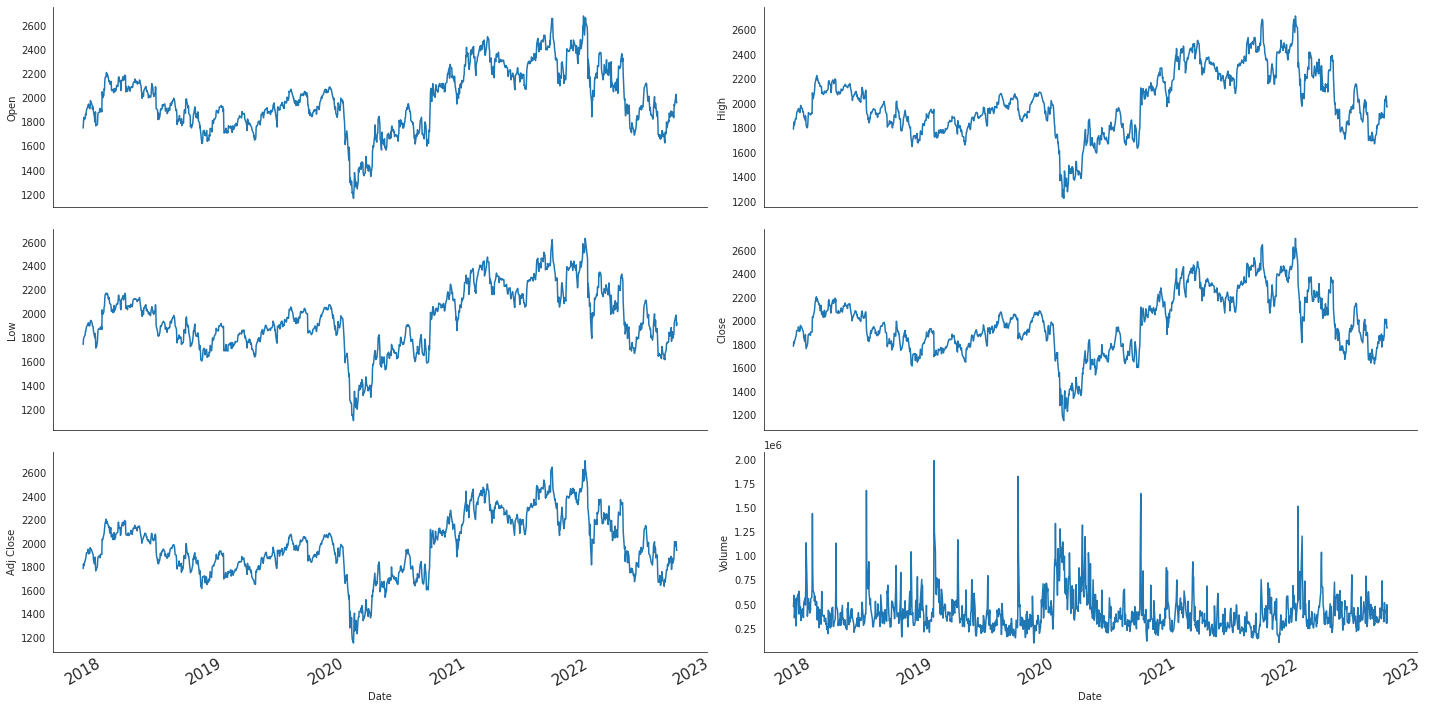

In [ ]:
symbol ='BKNG'
stock_company = 'Booking Holdings Inc'

start_date = '2018-01-01'
end_date =  date.today().strftime("%Y-%m-%d")

df = load(symbol,start_date, end_date)
print(df.head())

print(count(start_date, end_date))

plot(df)

# RNN

In [ ]:
sequence_length = 100 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)

h0 = x_train.shape[1] * x_train.shape[2]

(1231, 5)


In [ ]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"


SimpleRNN_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='RNN', lr=lr, loss=loss)

history, y_pred_simplernn, MAE_simplernn, MAPE_simplernn, MDAPE_simplernn = evaluate(SimpleRNN_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
28/28 [==============================] - 11s 226ms/step - loss: 7.1027 - val_loss: 20.7724
Epoch 2/50
28/28 [==============================] - 6s 224ms/step - loss: 1.8260 - val_loss: 0.0817
Epoch 3/50
28/28 [==============================] - 6s 216ms/step - loss: 0.1123 - val_loss: 0.0265
Epoch 4/50
28/28 [==============================] - 6s 223ms/step - loss: 0.0402 - val_loss: 0.0318
Epoch 5/50
28/28 [==============================] - 6s 224ms/step - loss: 0.0404 - val_loss: 0.0334
Epoch 6/50
28/28 [==============================] - 6s 215ms/step - loss: 0.0331 - val_loss: 0.0363
Epoch 7/50
28/28 [==============================] - 6s 223ms/step - loss: 0.0313 - val_loss: 0.0313
Epoch 8/50
28/28 [==============================] - 6s 217ms/step - loss: 0.0312 - val_loss: 0.0264
Epoch 9/50
28/28 [==============================] - 6s 216ms/step - loss: 0.0334 - val_loss: 0.0269
Epoch 10/50
28/28 [==============================] - 6s 222ms/step - loss: 0.0313 - val_loss: 0.02

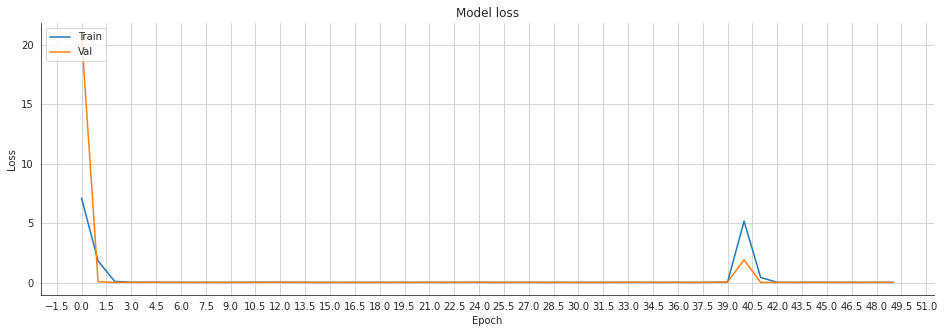

In [ ]:
loss_plot(history, epochs=epoch)

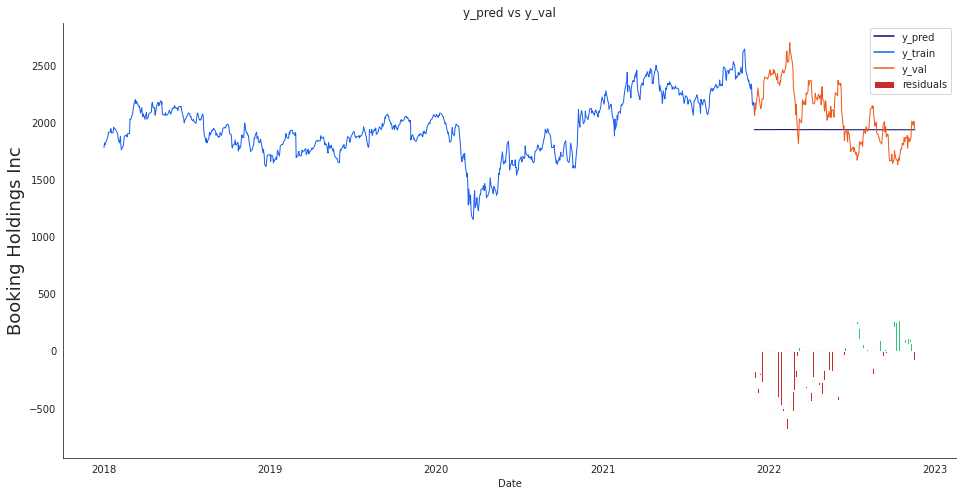

In [ ]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_simplernn, stock_company, display_start_date = start_date) # "2019-01-01")

# LSTM

In [ ]:
sequence_length = 100 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test = preprocess(df, seq_len = sequence_length)
h0 = x_train.shape[1] * x_train.shape[2]

(1231, 5)


In [ ]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"
LSTM_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='LSTM',lr=lr, loss=loss)
history, y_pred_LSTM, MAE_LSTM, MAPE_LSTM, MDAPE_LSTM = evaluate(LSTM_model, x_train, y_train, x_test, y_test, scaler_pred, epoch=epoch, batch_size=batch_size)


Epoch 1/50
28/28 [==============================] - 9s 61ms/step - loss: 0.0649 - val_loss: 0.0101
Epoch 2/50
28/28 [==============================] - 1s 24ms/step - loss: 0.0037 - val_loss: 0.0070
Epoch 3/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0032 - val_loss: 0.0067
Epoch 4/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 5/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 6/50
28/28 [==============================] - 1s 24ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 7/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 8/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 9/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 10/50
28/28 [==============================] - 1s 23ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 11/

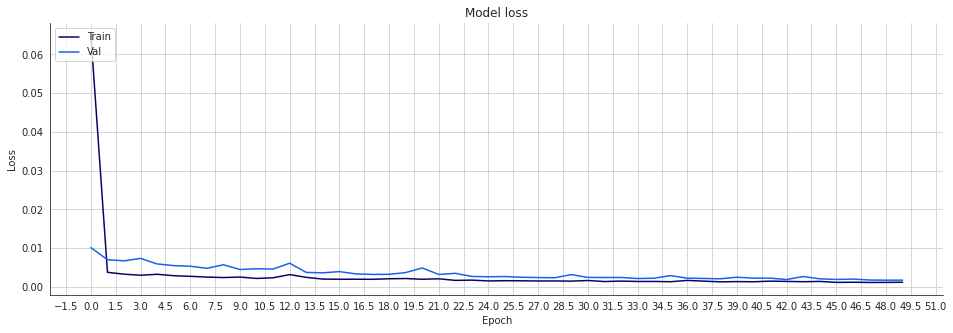

In [ ]:
loss_plot(history, epochs=epoch)

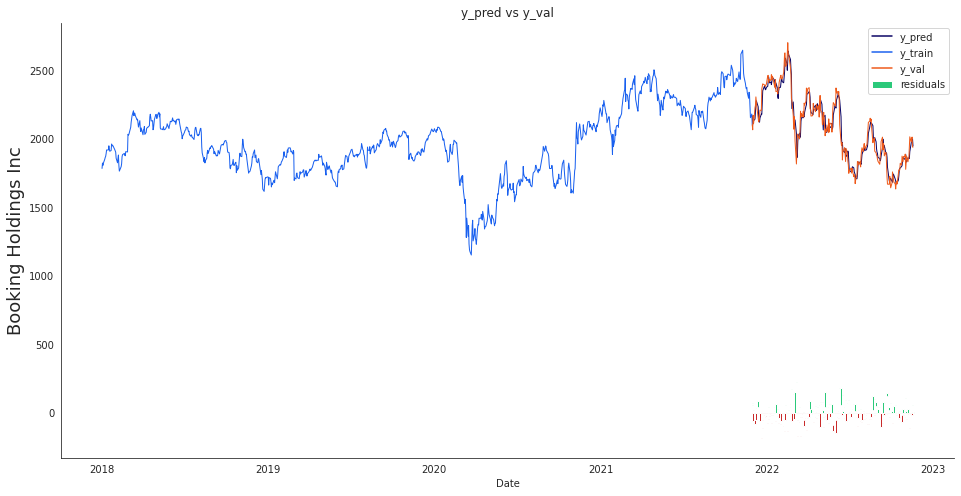

In [ ]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_LSTM, stock_company, display_start_date = start_date) #  "2019-01-01" )

# GRU

In [ ]:
sequence_length = 100 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)

h0 = x_train.shape[1] * x_train.shape[2]


(1231, 5)


In [ ]:
epoch=50
batch_size=32
lr=0.001
loss="mean_squared_error"

GRU_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]),  rnn_type='GRU',lr=lr, loss=loss)
history, y_pred_GRU, MAE_GRU, MAPE, MDAPE = evaluate(GRU_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
28/28 [==============================] - 6s 58ms/step - loss: 0.0572 - val_loss: 0.0073
Epoch 2/50
28/28 [==============================] - 1s 25ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 3/50
28/28 [==============================] - 1s 25ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 4/50
28/28 [==============================] - 1s 26ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 5/50
28/28 [==============================] - 1s 25ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 6/50
28/28 [==============================] - 1s 25ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 7/50
28/28 [==============================] - 1s 25ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 8/50
28/28 [==============================] - 1s 25ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/50
28/28 [==============================] - 1s 26ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 10/50
28/28 [==============================] - 1s 25ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 11/

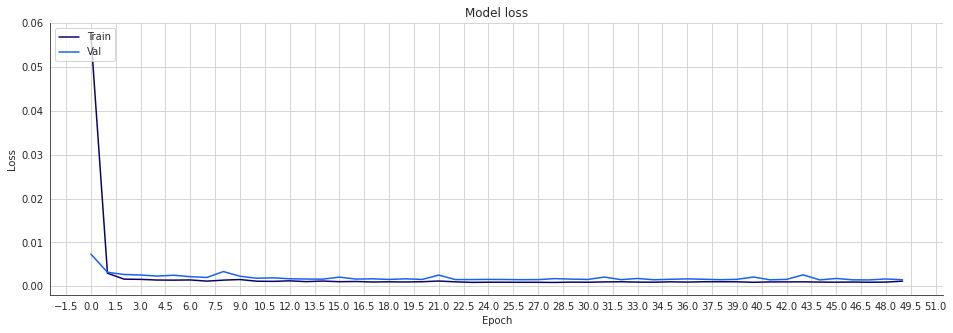

In [ ]:
loss_plot(history, epochs=epoch)

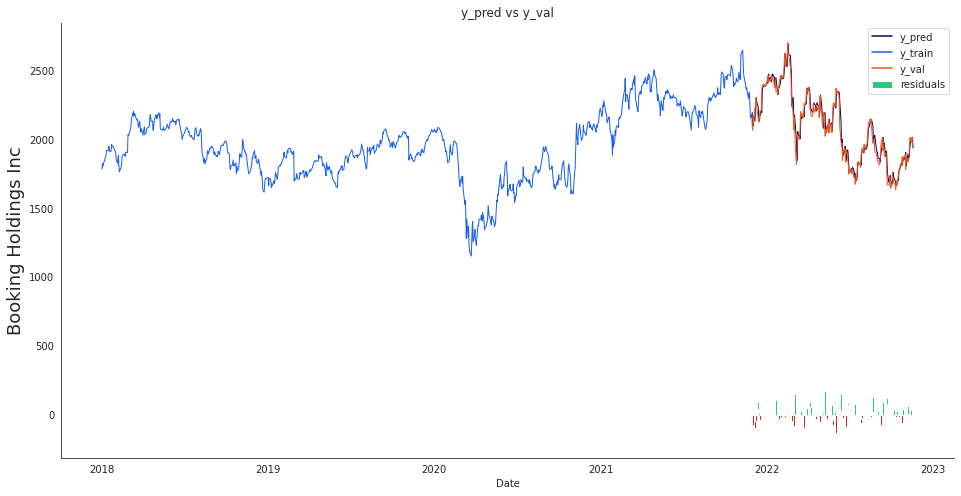

In [ ]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_GRU, stock_company, display_start_date = start_date)#= "2019-01-01" )

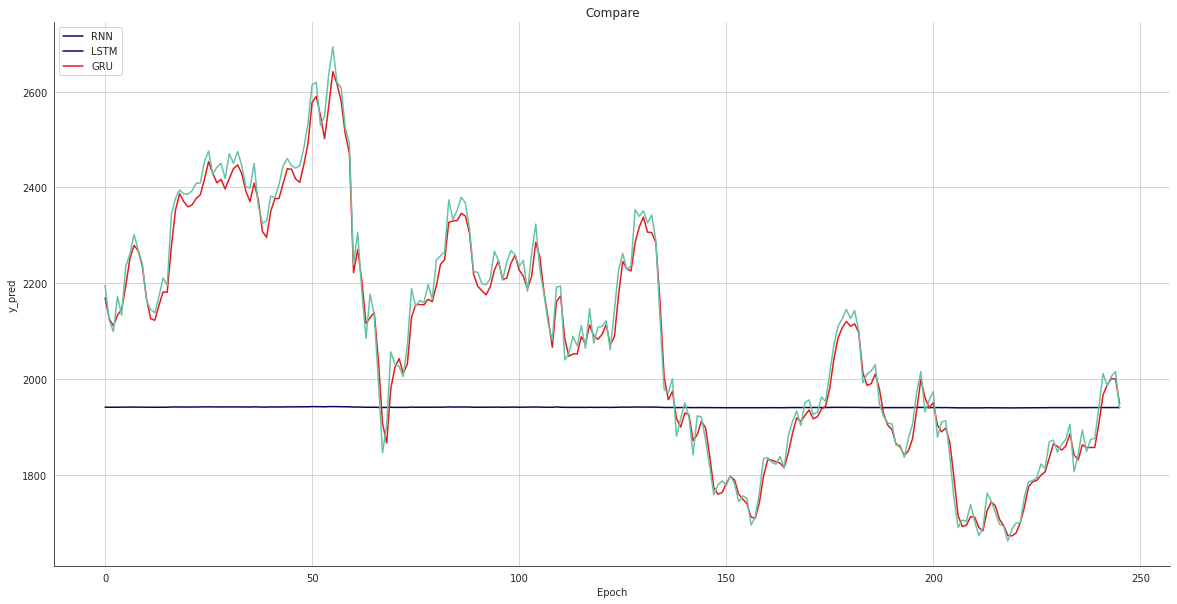

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=y_pred_simplernn)
sns.lineplot(data=y_pred_LSTM, palette="Set1")
sns.lineplot(data=y_pred_GRU,  palette="Set2")
plt.title("Compare")
plt.ylabel("y_pred")
plt.xlabel("Epoch")
plt.legend(["RNN", "LSTM", "GRU"], loc="upper left")
plt.grid()
plt.show()

# Predict Next Day


In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(stock_features)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_val data set to a numpy array and reshape the data
pred_price_scaled = LSTM_model.predict(np.array(X_test_new)) #try different model
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stock_company} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


1/1 [==============================] - 0s 23ms/step
The close price for NASDAQ at 2021-05-13 was 13031.68
The predicted close price is 12604.6201171875 (-3.39%)


In [ ]:
red_price_scaled = SimpleRNN_model.predict(np.array(X_test_new)) #try different model
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

positive = '+'; negative = ''
print(f'The close price for {stock_company} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({positive if negative > 0 else minus}{change_percent}%)')
